In [3]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For text preprocessing
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay


import torch 
import spacy
import torch.nn as nn
from collections import Counter

In [55]:
conda install -c conda-forge spacy

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
data = pd.read_csv("Constraint_English_Train - Sheet1.csv")
val = pd.read_csv("Constraint_English_Val - Sheet1.csv")
test = pd.read_csv("english_test_with_labels - Sheet1.csv")

In [5]:
print(f"Number of training samples: {len(data)}")
print(f"Number of validation samples: {len(val)}")
print(f"Number of testing samples: {len(test)}")

Number of training samples: 6420
Number of validation samples: 2140
Number of testing samples: 2140


<AxesSubplot:>

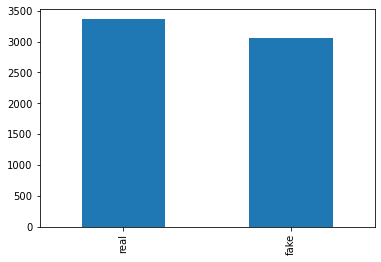

In [6]:
# Distribution of the training dataset
data['label'].value_counts().plot(kind='bar')

In [59]:
# !python -m spacy download en_core_web_sm

In [7]:
# Frequent words in the English language which would not aid classification
stop_words = set(stopwords.words("english"))
tok = spacy.load('en_core_web_sm')
def process_text(string):
    """
    Replaces "http", "www" in urls with space.
    Replaces ampersand(&) with "and"
    Removes non-alphanumeric characters
    Removes stop words
    """
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stop_words]
    text = " ".join(text)
    text = [token.text for token in tok.tokenizer(text)]
    return text

In [61]:
data['tweet'] = data['tweet'].apply(lambda x: process_text(x))
val['tweet'] = val['tweet'].apply(lambda x: process_text(x))
test['tweet'] = test['tweet'].apply(lambda x: process_text(x))

In [62]:
data.head()

,id,tweet,label
0,1,"[cdc, currently, reports, 99031, deaths, gener...",real
1,2,"[states, reported, 1121, deaths, small, rise, ...",real
2,3,"[politically, correct, woman, almost, uses, pa...",fake
3,4,"[indiafightscorona, 1524, covid, testing, labo...",real
4,5,"[populous, states, generate, large, case, coun...",real


In [63]:
sum(data['tweet'].apply(lambda x : len(x)))/len(data['tweet'])

17.5398753894081

In [64]:
counts = Counter()
for index, row in data.iterrows():
    counts.update(row['tweet'])

In [65]:
vocab2idx = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2idx[word] = len(words)
    words.append(word)

In [66]:
def encode_sentence(text, vocab2index, N=32):
    encoded = np.zeros(N, dtype=int)
    enc = np.array([vocab2idx.get(word, vocab2idx["UNK"]) for word in text])
    length = min(N, len(enc))
    encoded[:length] = enc[:length]
    return encoded, length

In [67]:
data['encoded'] = data['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))
data.head()

/var/folders/0k/h8p0bgts4g5113f9brnt4l4w0000gn/T/ipykernel_92559/2487720325.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data['encoded'] = data['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))


,id,tweet,label,encoded
0,1,"[cdc, currently, reports, 99031, deaths, gener...",real,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,2,"[states, reported, 1121, deaths, small, rise, ...",real,"[[21, 22, 23, 6, 13, 24, 25, 26, 27, 21, 22, 2..."
2,3,"[politically, correct, woman, almost, uses, pa...",fake,"[[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ..."
3,4,"[indiafightscorona, 1524, covid, testing, labo...",real,"[[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, ..."
4,5,"[populous, states, generate, large, case, coun...",real,"[[58, 21, 59, 60, 61, 10, 62, 63, 64, 65, 66, ..."


In [68]:
val['encoded'] = val['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))
test['encoded'] = test['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))

/var/folders/0k/h8p0bgts4g5113f9brnt4l4w0000gn/T/ipykernel_92559/17374283.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val['encoded'] = val['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))
/var/folders/0k/h8p0bgts4g5113f9brnt4l4w0000gn/T/ipykernel_92559/17374283.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test['encoded'] = test['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))


In [69]:
data['label_encoded'] = data['label'].apply(lambda x : 0 if x == "fake" else 1)
val['label_encoded'] = val['label'].apply(lambda x : 0 if x == "fake" else 1)
test['label_encoded'] = test['label'].apply(lambda x : 0 if x == "fake" else 1)

In [70]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [71]:
class TweetDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0]), self.y[idx], self.X[idx][1]
    
    def __len__(self):
        return len(self.y)
    

In [72]:
train_data = TweetDataset(data['encoded'], data['label_encoded'])
val_data = TweetDataset(val['encoded'], val['label_encoded'])
test_data = TweetDataset(test['encoded'], test['label_encoded'])

In [73]:
batch_size = 128
vocab_size = len(words)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size)
testloader = DataLoader(test_data, batch_size=batch_size)

In [74]:
def train_model(model, epochs=10, lr=0.001):
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    criterion = nn.BCELoss()
    
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in trainloader:
            print(x)
            x = x.long()
            y = y.float()
            yhat = model(x, l).squeeze()
            # print(y)
            # print(yhat)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        
        model.eval()
        correct = 0
        total = 0
        sum_loss_val = 0.0

        for x, y, l in valloader:
            x = x.long()
            y = y.float()
            y_hat = model(x, l).squeeze()
            loss = criterion(y_hat, y)
            # print(y_hat)
            pred = y_hat >= 0.5
            # print(pred)
            correct += (pred == y).float().sum()
            total += y.shape[0]
            sum_loss_val += loss.item()*y.shape[0]

        val_acc = correct/total
        val_loss = sum_loss/total
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))


In [75]:
class LSTM_fixed(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super(LSTM_fixed, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return F.sigmoid(self.linear(ht[-1]))

In [76]:
model_fixed =  LSTM_fixed(vocab_size, 64, 64)

In [134]:
train_model(model_fixed, epochs=30, lr=0.01)

train loss 1.583, val loss 1.583, val accuracy 0.767
train loss 0.244, val loss 0.244, val accuracy 0.902
train loss 0.069, val loss 0.069, val accuracy 0.899
train loss 0.074, val loss 0.074, val accuracy 0.893
train loss 0.018, val loss 0.018, val accuracy 0.900
train loss 0.032, val loss 0.032, val accuracy 0.900


In [137]:
model_fixed.eval()
correct = 0
total = 0
sum_loss_test = 0.0
criterion = nn.BCELoss()

for x, y, l in testloader:
    x = x.long()
    y = y.float()
    y_hat = model_fixed(x, l).squeeze()
    loss = criterion(y_hat, y)
    pred = y_hat >= 0.5
    correct += (pred == y).float().sum()
    total += y.shape[0]
    sum_loss_test += loss.item()*y.shape[0]


In [138]:
correct/total

tensor(0.9079)

In [144]:
def load_glove_vectors(glove_file="./glove.6B.100d.txt"):
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [148]:
def glove_emb_matrix(pretrained, word_counts, emb_size = 100):
    """ 
    Creates embedding matrix from word vectors
    """
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [149]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = glove_emb_matrix(word_vecs, counts)

In [162]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        # self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return F.sigmoid(self.linear(ht[-1]))

In [168]:
model = LSTM_glove_vecs(vocab_size, 100, 64, pretrained_weights)

In [169]:
train_model(model, epochs=30, lr=0.01)

train loss 1.004, val loss 1.004, val accuracy 0.886
train loss 0.320, val loss 0.320, val accuracy 0.930
train loss 0.017, val loss 0.017, val accuracy 0.929
train loss 0.058, val loss 0.058, val accuracy 0.921
train loss 0.005, val loss 0.005, val accuracy 0.924
train loss 0.030, val loss 0.030, val accuracy 0.924


In [170]:
model_fixed.eval()
correct = 0
total = 0
sum_loss_test = 0.0
criterion = nn.BCELoss()

for x, y, l in testloader:
    x = x.long()
    y = y.float()
    y_hat = model(x, l).squeeze()
    loss = criterion(y_hat, y)
    pred = y_hat >= 0.5
    correct += (pred == y).float().sum()
    total += y.shape[0]
    sum_loss_test += loss.item()*y.shape[0]


In [171]:
correct/total

tensor(0.9243)